## Assignment 8 - Generate new picture using VAE
##### Natalie Kim
This is to develop an understanding of Variational AutoEncoders.

Use the code from https://keras.io/examples/generative/vae/Links to an external site..

Change the dimensions of the input images from 28-by-28 to 200-by-200 using

You will have to change the Dense layer of the decoder to be a factor of 200 (instead of a factor of 28).

Select 2 different pictures with larger than 200-by-200 dimensions.

Remember to submit the pictures with your code.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from matplotlib import pyplot as plt

In [4]:
## Create a sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [21]:
"""
## Build the encoder
"""
latent_dim = 2

encoder_inputs = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │     18,496 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 160000)    │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │  2,560,016 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,579,476 (9.84 MB)

 Trainable params: 2,579,476 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
"""
## Build the decoder
"""
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 * 50 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((50, 50, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160000)         │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 200, 200, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,259 (2.05 MB)

 Trainable params: 536,259 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### 1. Train VAE. Fit the VAE model using one of the 2 pictures, call it pic_1.
Trim the picture to fit the input 200-by-200 dimensions using

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(200, 200))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, 0).astype("float32") / 255
    return img_array

# Load images
pic_1 = preprocess_image("/Users/nataliekim/Desktop/bean copy.png")
pic_2 = preprocess_image("/Users/nataliekim/Desktop/utah.jpeg")

In [29]:
"""
## Train the VAE
"""
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pic_1, epochs=100, batch_size=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - kl_loss: 7.5190 - loss: 23315.3867 - reconstruction_loss: 23307.8672
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - kl_loss: 2.4511 - loss: 24519.8008 - reconstruction_loss: 24517.3496
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - kl_loss: 4.8631 - loss: 23049.0703 - reconstruction_loss: 23044.2070
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - kl_loss: 9.9281 - loss: 22919.4609 - reconstruction_loss: 22909.5332
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - kl_loss: 12.9776 - loss: 22725.5371 - reconstruction_loss: 22712.5586
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - kl_loss: 15.7111 - loss: 24293.3203 - reconstruction_loss: 24277.6094
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - kl_loss: 17.8506 - loss: 22450.6055 - reconstruction_loss: 22432.7539
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - kl_loss: 21.5660 - loss: 22318.9297 - reconstruction_loss: 22297.3633
Epoch 9/100
1/1 ━━━━━━━━━━━

### 2. Sample the latent space. Explain the code in the Sampling function

The sampling layer (defined and executed above) first takes in the mean of the latent space distribution ('z_mean') and the log varaince of the latent space distribution ('z_log_var'). Then determines the batch size and latent dimensionality. It then generates random noise ('epsilon') before computing the latent vector sample by applying the reparameterization trick. This ensures that the gradients can be backpropagated through the sampling process and thus gradient descent optimization.

### 3. Generate Images. Then use the same picture to generate a new copy as follows:
Note that decoded_img should be a newly generated copy of pic_1.
Run the encoder-decoder multiple times to confirm that each run generates a new copy of pic_1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[0.9580683 3.7779737]] [[-4.230964  1.361109]]
[[0.99471813 6.666208  ]]


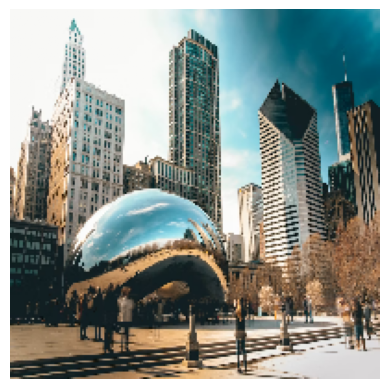

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1, 200, 200, 3)


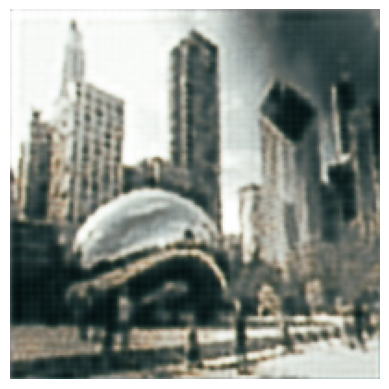

In [30]:
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print(z_mean, z_log_var)
print(encoded_imgs)

show_plot(pic_1)

decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)
show_plot(decoded_imgs)

### 4. New input data.
Rerun the generate copy code with the other picture, call it pic_2.

What output do you see? Explain why.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[0.5862622 2.2544026]] [[-2.4982986  0.7854147]]
[[0.888121 3.088389]]


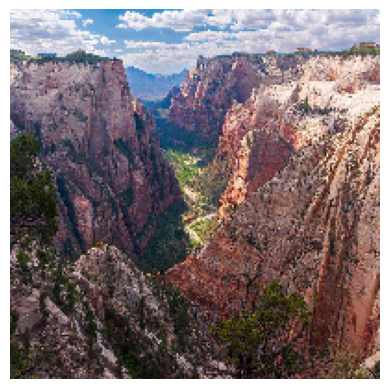

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1, 200, 200, 3)


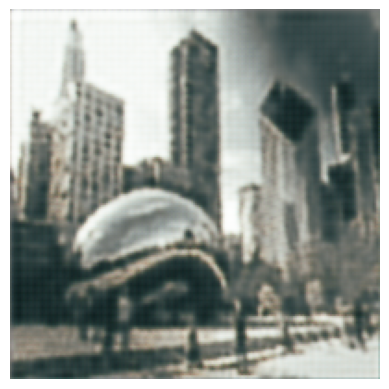

In [31]:
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_2)

print(z_mean, z_log_var)
print(encoded_imgs)

show_plot(pic_2)

decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)
show_plot(decoded_imgs)

Since the VAE model is trained only on pic_1 and not on pic_2, the generaged output is expected - an image of pic_1. The latent space representation will be based upon the features learned from pic_1. We can see that the generated image above is slighly distorted, but is still very clearly a resemblance of pic_1.